In [8]:
import pandas as pd
import geopandas as gpd
import os
import requests
import esda
import libpysal
import multiprocessing as mp
import itertools
import pygeos
import subprocess
import json
import sys
import shapely
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

In [10]:
tqdm.pandas()

In [2]:
output_path = './Multi_F_Results'

In [3]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

mi = gpd.GeoDataFrame()
for i in range(0, 15):
    temp_path = os.path.join(output_path, f'N_{i}', f'Multi_F_mi.geojson')
    if os.path.exists(temp_path):
        temp_ = gpd.read_file(temp_path)
        temp_['iter'] = i
        mi = pd.concat([mi, temp_], ignore_index=True)

mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')

mi = mi.to_crs(epsg=5070)

mi.head()

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,pval_GROUPQ,dist_GROUPQ,geometry,iter,STATE,Name,Abbr,FIPS,ContiguousUS,Region
0,CA10114,36.416309,-119.003224,TERMINUS DAM,199,dam_study,True,False,True,True,...,1.669153e-04,25000,POINT (-2023906.324 1731514.024),0,CA,California,CA,6,1,Pacific
1,CA10113,36.060671,-118.919340,Richard L. Schafer Dam,98,dam_study,True,False,True,True,...,4.774998e-05,2500,POINT (-2026183.366 1691051.608),0,CA,California,CA,6,1,Pacific
2,NY00468,42.733294,-77.907232,MOUNT MORRIS DAM,316,dam_study,True,False,True,True,...,1.407998e-07,7500,POINT (1463933.450 2332679.707),0,NY,New York,NY,36,1,MiddleAtlantic
3,CA10109,38.151041,-120.813699,NEW HOGAN DAM,297,dam_study,True,False,True,True,...,3.889230e-03,25000,POINT (-2129517.012 1959358.301),0,CA,California,CA,6,1,Pacific
4,CA10104,37.906801,-120.934059,FARMINGTON DAM,260,dam_study,True,False,True,True,...,6.221346e-02,1000,POINT (-2146709.171 1935623.650),0,CA,California,CA,6,1,Pacific


In [4]:
states = gpd.read_file('./data_plot/tl_2022_us_state.shp')
states = states.loc[states['STUSPS'].isin(state_lookup.loc[state_lookup['ContiguousUS'] == 1, 'Abbr'].values)]
us_geom = states['geometry'].unary_union
states = states.to_crs(epsg=5070)

In [5]:
dams = pd.read_csv('./data_plot/nation.csv', header=1)
dams = gpd.GeoDataFrame(dams, geometry=gpd.points_from_xy(dams.Longitude, dams.Latitude, crs='EPSG:4326'))
dams = dams.reset_index(drop=True)
# dams_sc = dams.loc[dams['geometry'].intersects(county_dis['geometry'].values[0])]
print(dams.shape)
dams.head(1)

(92072, 76)


/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_26420/316814696.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  dams = pd.read_csv('./data_plot/nation.csv', header=1)


,Dam Name,Other Names,Former Names,NID ID,Other Structure ID,Federal ID,Owner Names,Owner Types,Primary Owner Type,State or Federal Agency ID,...,Data Last Updated,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,Condition Assessment Date,EAP Prepared,EAP Last Revision Date,Website URL,geometry
0,Dod Usa 2,NaN,Dod Usa,OK20994,NaN,OK20994,DEPT. OF DEFENSE/US ARMY RESERVE CENTER,Federal,Federal,NaN,...,2018-06-22,1998-10-01,5.0,Low,Not Rated,NaN,Not Required,NaN,https://damsafety.org/oklahoma,POINT (-95.13638 35.70341)


In [18]:
dams_geom = pygeos.from_shapely(dams['geometry'].values)
dams_geom_tree = pygeos.STRtree(dams_geom, leafsize=50)

us_geom_union = pygeos.from_shapely(us_geom)
query_intersect = dams_geom_tree.query(us_geom_union, predicate='intersects')

dams_us = dams.loc[query_intersect]
dams_us = dams_us.to_crs(epsg=5070)
dams_us.head(3)

,Dam Name,Other Names,Former Names,NID ID,Other Structure ID,Federal ID,Owner Names,Owner Types,Primary Owner Type,State or Federal Agency ID,...,Data Last Updated,Last Inspection Date,Inspection Frequency,Hazard Potential Classification,Condition Assessment,Condition Assessment Date,EAP Prepared,EAP Last Revision Date,Website URL,geometry
16422,Terminal,Lopez Reservoir,NaN,CA00888,NaN,CA00888,San Luis Obispo County Flood Control and Water...,Local Government,Local Government,1055.002,...,2021-04-09,2020-11-19,1.0,High,Satisfactory,2017-09-01,Yes,2019-11-19,https://damsafety.org/california,POINT (-2191372.400 1630255.264)
41413,Righetti,NaN,NaN,CA00725,NaN,CA00725,Private Entity,Private,Private,743.000,...,2021-04-09,2020-11-17,1.0,High,Satisfactory,2017-09-01,No,NaN,https://damsafety.org/california,POINT (-2193503.018 1639997.595)
68184,Chorro Creek,Chorro Reservoir,NaN,CA01076,NaN,CA01076,California Department of Corrections and Rehab...,State,State,1.072,...,2021-04-09,2020-01-24,1.0,High,Satisfactory,2017-09-01,Yes,2020-08-18,https://damsafety.org/california,POINT (-2199961.463 1651876.428)


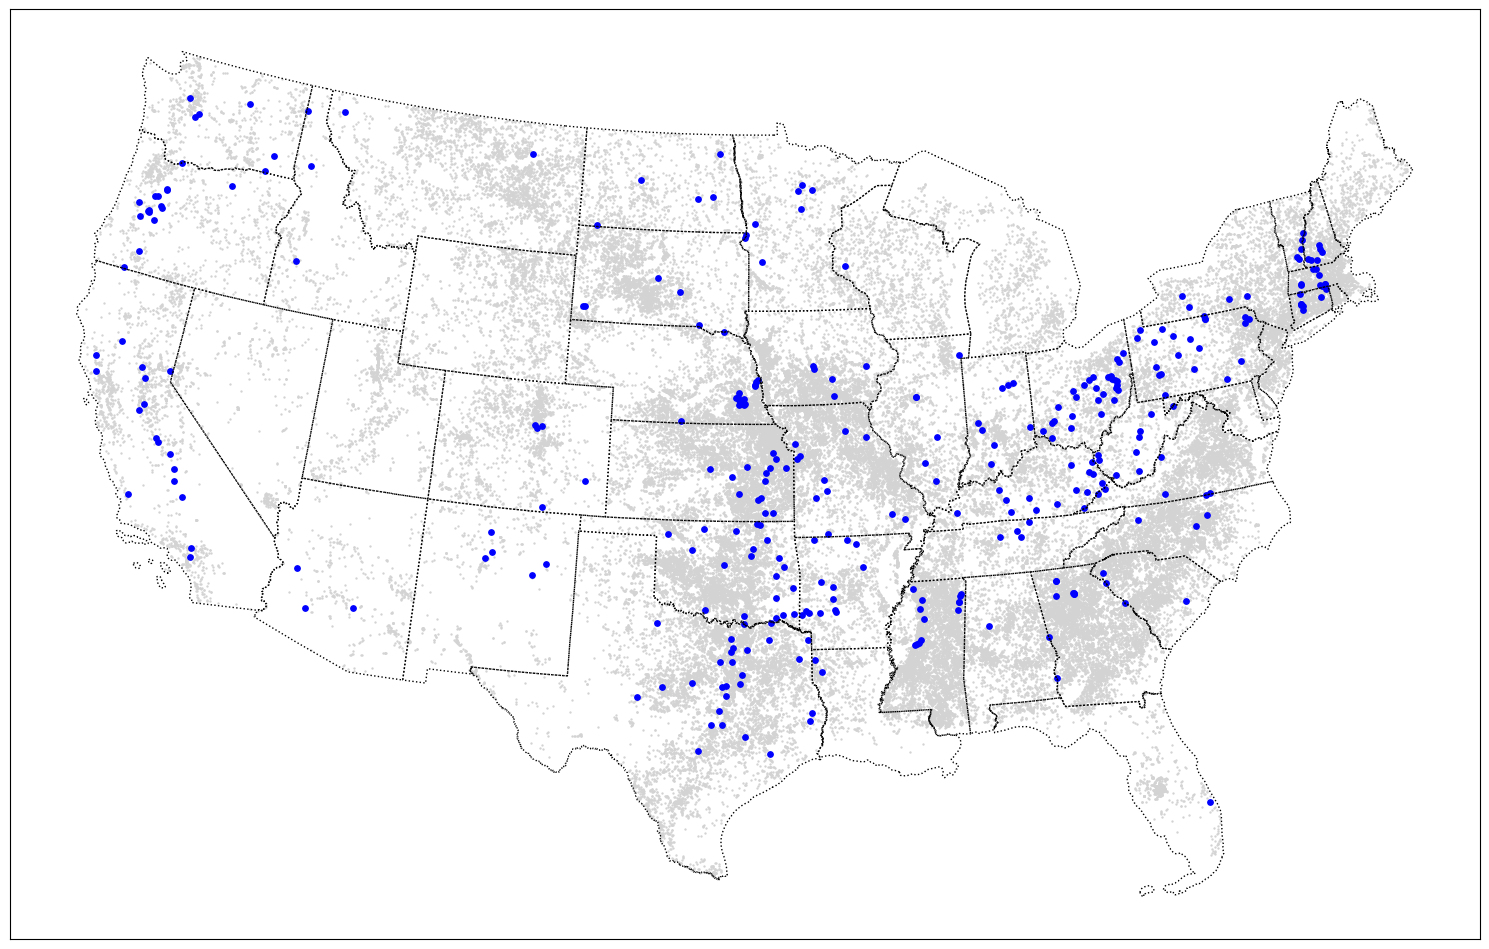

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))

dams_us.plot(ax=ax, color='lightgrey', markersize=0.5)
mi.plot(ax=ax, color='blue', markersize=15)
states.boundary.plot(ax=ax, linewidth=1, edgecolor='k', linestyle=':')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Plot three inundation maps for a single dam 

In [24]:
dam_id = 'TX00018'
iter_num = mi.loc[mi['ID'] == dam_id, 'iter'].values[0]
iter_num

13

In [25]:
fim = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', f'Multi_F_fim.geojson'))
lm = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', f'Multi_F_lm.geojson'))
fim = fim.loc[fim['Dam_ID'] == dam_id]
lm = lm.loc[lm['Dam_ID'] == dam_id]

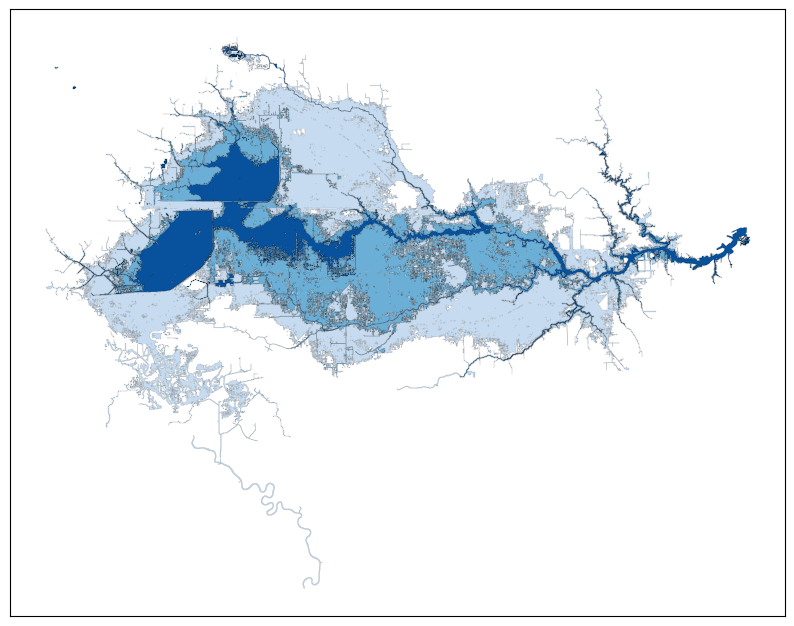

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

color_brewer = ['#c6dbef','#6baed6','#08519c']
# ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
# color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=3)
fim = fim.to_crs(epsg=4326)

fim.plot('value', ax=ax, cmap=cm)
fim.boundary.plot(ax=ax, linewidth=0.05, color='black')
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
lm = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', f'Multi_F_lm.geojson'))
lm

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,dist_MUNIT,LISA_MOBILE,dist_MOBILE,LISA_CROWD,dist_CROWD,LISA_NOVEH,dist_NOVEH,LISA_GROUPQ,dist_GROUPQ,geometry
0,21.863669,12.9,15.023847,12.3,8.9,24.6,18.358531,21.3,6.120827,1.587302,...,50000,HH,50000,HL,50000,HL,50000,Not_Sig,5000,"POLYGON ((-93.92510 33.72958, -93.92482 33.730..."
1,21.863669,12.9,15.023847,12.3,8.9,24.6,18.358531,21.3,6.120827,1.587302,...,50000,HH,50000,HL,50000,HL,50000,Not_Sig,5000,"POLYGON ((-93.92261 33.73284, -93.92260 33.732..."
2,21.863669,12.9,15.023847,12.3,8.9,24.6,18.358531,21.3,6.120827,1.587302,...,50000,HH,50000,HL,50000,HL,50000,Not_Sig,5000,"POLYGON ((-93.96965 33.73979, -93.96955 33.740..."
3,21.863669,12.9,15.023847,12.3,8.9,24.6,18.358531,21.3,6.120827,1.587302,...,50000,HH,50000,HL,50000,HL,50000,HL,5000,"POLYGON ((-93.91180 33.70720, -93.91176 33.707..."
4,21.863669,12.9,15.023847,12.3,8.9,24.6,18.358531,21.3,6.120827,1.587302,...,50000,HH,50000,HL,50000,HL,50000,HL,5000,"POLYGON ((-93.93791 33.70655, -93.93710 33.707..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77588,52.576197,30.4,22.580645,12.4,28.7,10.1,28.731478,10.4,10.967742,0.000000,...,1000,HL,1000,HL,1000,HH,5000,HL,5000,"POLYGON ((-101.38003 44.65823, -101.37999 44.6..."
77589,52.576197,30.4,22.580645,12.4,28.7,10.1,28.731478,10.4,10.967742,0.000000,...,1000,HL,1000,HL,1000,HH,5000,HL,5000,"POLYGON ((-101.38003 44.65686, -101.37996 44.6..."
77590,52.576197,30.4,22.580645,12.4,28.7,10.1,28.731478,10.4,10.967742,0.000000,...,1000,Not_Sig,1000,HL,1000,HH,5000,Not_Sig,5000,"POLYGON ((-101.29565 44.68994, -101.29537 44.6..."
77591,52.576197,30.4,22.580645,12.4,28.7,10.1,28.731478,10.4,10.967742,0.000000,...,1000,LL,1000,LL,1000,LH,5000,Not_Sig,5000,"POLYGON ((-101.39742 44.65719, -101.39738 44.6..."


In [37]:
lm['Class'].unique()

array([3, 2, 1])

In [38]:
lm.loc[lm['Class']==1]

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,dist_MUNIT,LISA_MOBILE,dist_MOBILE,LISA_CROWD,dist_CROWD,LISA_NOVEH,dist_NOVEH,LISA_GROUPQ,dist_GROUPQ,geometry
7701,19.667360,4.1,21.274038,8.3,0.7,21.6,23.160000,21.0,4.326923,0.042790,...,2500,LL,10000,Not_Sig,1000,Not_Sig,50000,LH,7500,"POLYGON ((-90.90969 39.39989, -90.90868 39.400..."
7704,19.667360,4.1,21.274038,8.3,0.7,21.6,23.160000,21.0,4.326923,0.042790,...,2500,LL,10000,Not_Sig,1000,Not_Sig,50000,LH,7500,"POLYGON ((-90.90116 39.39395, -90.90113 39.395..."
7729,19.667360,4.1,21.274038,8.3,0.7,21.6,23.160000,21.0,4.326923,0.042790,...,2500,Not_Sig,10000,LL,1000,LH,50000,LH,7500,"POLYGON ((-90.72815 39.26243, -90.72771 39.262..."
7730,19.667360,4.1,21.274038,8.3,0.7,21.6,23.160000,21.0,4.326923,0.042790,...,2500,Not_Sig,10000,LL,1000,Not_Sig,50000,LH,7500,"POLYGON ((-90.71816 39.23408, -90.71454 39.233..."
7770,8.709107,4.8,10.735826,4.4,1.3,26.2,17.747590,15.9,0.241255,0.000000,...,2500,Not_Sig,10000,LL,1000,LH,50000,Not_Sig,7500,"POLYGON ((-90.67172 39.07042, -90.67169 39.071..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73286,9.680968,1.4,16.325224,5.5,4.3,24.1,21.960570,9.9,4.161332,0.227467,...,50000,Not_Sig,2500,LL,50000,LL,2500,Not_Sig,5000,"POLYGON ((-100.92598 41.10525, -100.92593 41.1..."
74463,14.383315,2.2,14.837398,5.9,2.8,13.6,26.158821,11.7,2.337398,0.000000,...,1000,Not_Sig,1000,Not_Sig,1000,LL,5000,LL,5000,"POLYGON ((-100.41367 46.82369, -100.41350 46.8..."
74929,12.866667,0.7,16.038186,8.3,4.9,27.9,21.179800,11.0,4.009547,0.367563,...,1000,Not_Sig,1000,Not_Sig,1000,Not_Sig,5000,Not_Sig,5000,"POLYGON ((-101.42486 47.63032, -101.42484 47.6..."
76784,12.202596,0.0,19.436946,1.9,8.1,18.1,23.007117,11.8,4.820671,0.536441,...,1000,LL,1000,LH,1000,LH,5000,LH,5000,"POLYGON ((-100.35884 44.38050, -100.35883 44.3..."


<Axes: >

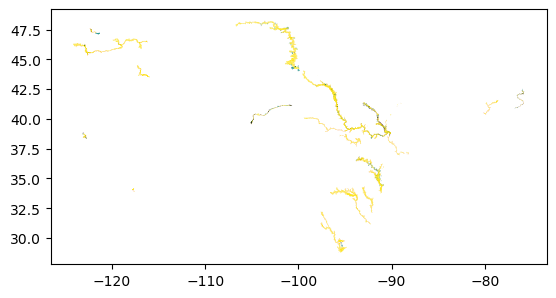

In [39]:
lm.plot('Class')